# Masking Useful Data

In this notebook, we attempt to create an image preprocessing tool for the hyperspectral "crate" data. The tool classifies clusters of rocks that we label by hand for a single image and test on other images. The model procedure is as follows:

1. PCA dimensionality reduction and unit scaling.
2. K-Means clustering
3. labeling by hand.
4. Neural network classifier.

PCA is used because K-Means tends to perform poorly on high-dimensional data, and kmeans is known to perform best when all axes are similarly scaled. A small number of clusters appeared to work best by visual inspection. A neural network was used to accomodate the large scale of the data (~180k samples per image) for creating a classifier that accomodated both the information from clustering and pre-provided mask.

In [160]:
import spectral as sp
import spectral.io.envi as envi

import numpy as np
import scipy as sc

import pandas as pd

import sklearn
import skimage
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.kernel_approximation import RBFSampler, Nystroem
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from skimage.restoration import denoise_wavelet
from skimage import img_as_float
from skimage.color import rgb2gray

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import seaborn as sns
# sns.set()

import joblib

def to_rgb(x):
    bands = [145,(411+145)//2,411-1]
    rgb = x[...,bands]
    for i in range(3):
        l,u = rgb[...,i].min(), rgb[...,i].max()
        rgb[...,i] = (rgb[...,i] - l) / (u - l)
    return np.clip(rgb,0,1)

## Load and Visualize the Data

__note:__ The header files as provided are missing a line that is required for loading the file with the spectral library. Be sure to add the line:

```
byte order = 0
```

anywhere after the first line. Please see the [ENVI header file documentation](https://www.harrisgeospatial.com/docs/ENVIHeaderFiles.html).

In [57]:
img = envi.open("data/VNIR and SWIR interval/CMM-111_195_extracted_image.hdr", "data/VNIR and SWIR interval/CMM-111_195_extracted_image.img")

In [58]:
hypr_c195 = img.load()
hypr_shape = hypr_c195.shape
print(f"image shape: {hypr_shape}")
wavelengths = np.array(img.bands.centers)
print(f"wavelength range: {(wavelengths[0], wavelengths[-1])}")

image shape: (527, 337, 411)
wavelength range: (463.31, 2476.54)


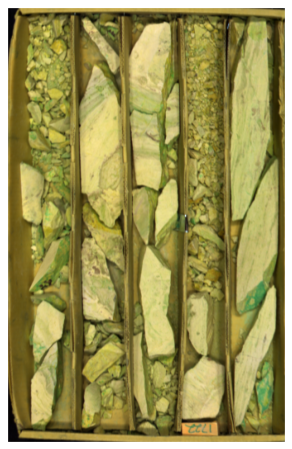

In [146]:
plt.figure(figsize=(10,8))
plt.imshow(to_rgb(hypr_c195))
plt.xticks([])
plt.yticks([])
plt.show()

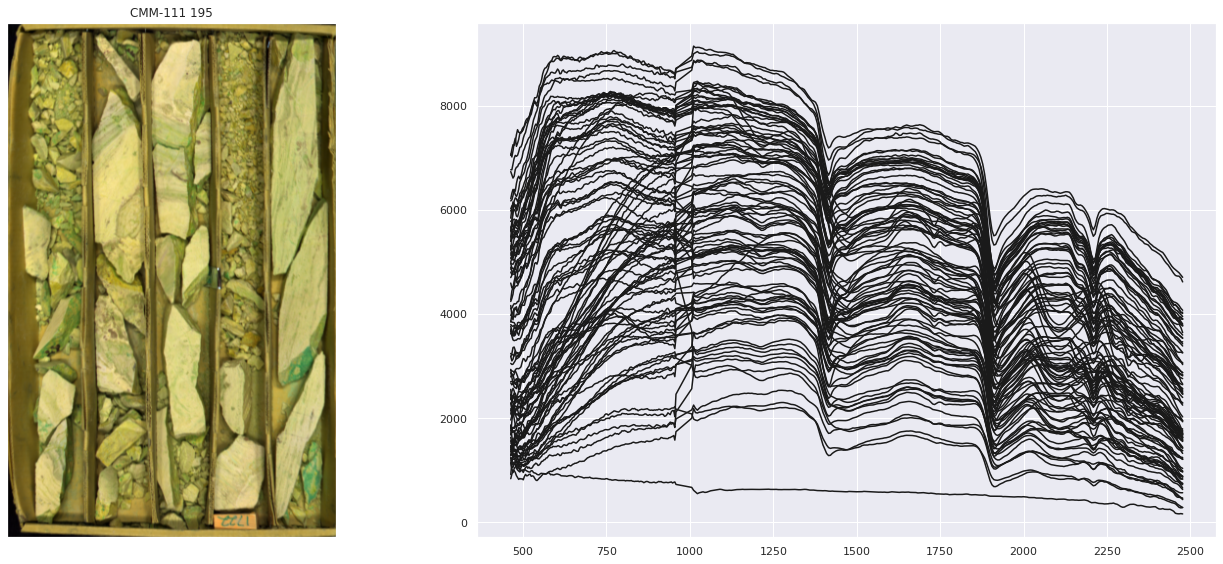

In [147]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
img_rgb = to_rgb(hypr_c195)
plt.imshow(img_rgb)
plt.title("CMM-111 195")
plt.xticks([]); plt.yticks([])

plt.subplot(1,2,2)
plt.plot(
    wavelengths,
    pd.DataFrame(hypr_c195.reshape(-1,411)).sample(100).values.T,
    '-k'
)

plt.tight_layout()
plt.show()

## Mask Provided
We have also been provided a mask that indicates the regions of interest. However, this mask only erases the crate itself and does not filter out the gravel which is not usable. Nevertheless, it is still valuable for preprocessing.

In [148]:
mask_c195 = plt.imread('data/Core Mask/VN-SWIR_Core_Mask_CMM-111_195@1719_1726.tiff')
mask_c195 = rgb2gray(mask_c195).astype(bool)

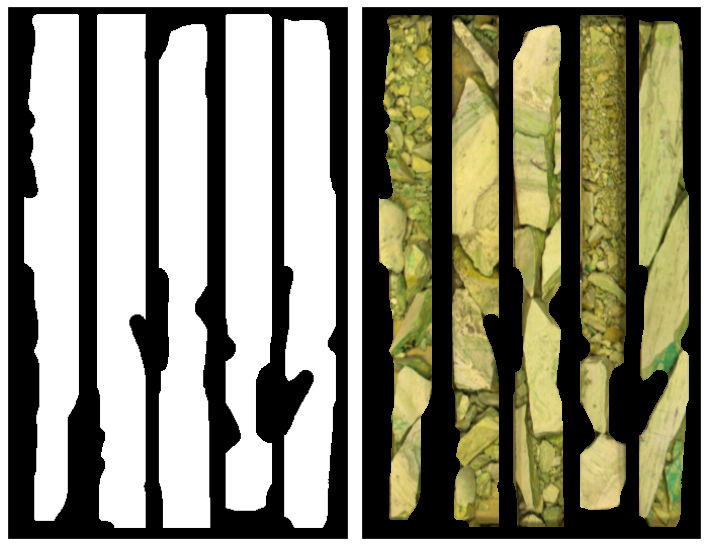

In [149]:
plt.figure(figsize=(10,16))
plt.subplot(1,2,1)
plt.imshow(mask_c195, cmap='binary_r')
plt.xticks([]); plt.yticks([])

plt.subplot(1,2,2)
abc = img_rgb.copy()
abc[~mask_c195,:] = np.nan
plt.imshow(abc)
plt.xticks([]); plt.yticks([])

plt.tight_layout()
plt.show()

In [150]:
hypr = hypr_c195[mask_c195,:] ## we select only the white parts of the mask
hypr = hypr.reshape(-1, 411)

## PCA + K-Means
good old fashioned clustering

We can optionally exclude the VNIR data, that is, include only the SWIR data. We can not necessarily justify this, however, this seems to work well.

In [74]:
swir_range, = np.where(wavelengths >= 1000)
hypr = hypr[:,swir_range]

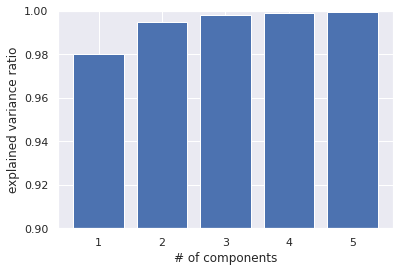

[0.98008764 0.99486476 0.9980591  0.99923426 0.99951965]
[5333.578    654.91187  304.4941   184.68489   91.0149 ]


In [75]:
pca = TruncatedSVD(n_components=5)
pl  = Pipeline([('scale',StandardScaler()),('pca',pca)])
hyprT = pl.fit_transform(hypr)

plt.bar(np.arange(1,5+1),
        np.cumsum(pca.explained_variance_ratio_),
        )
plt.xlabel('# of components')
plt.ylabel('explained variance ratio')
plt.ylim([0.9,1])
plt.show()

print(np.cumsum(pca.explained_variance_ratio_))
print(pca.singular_values_)

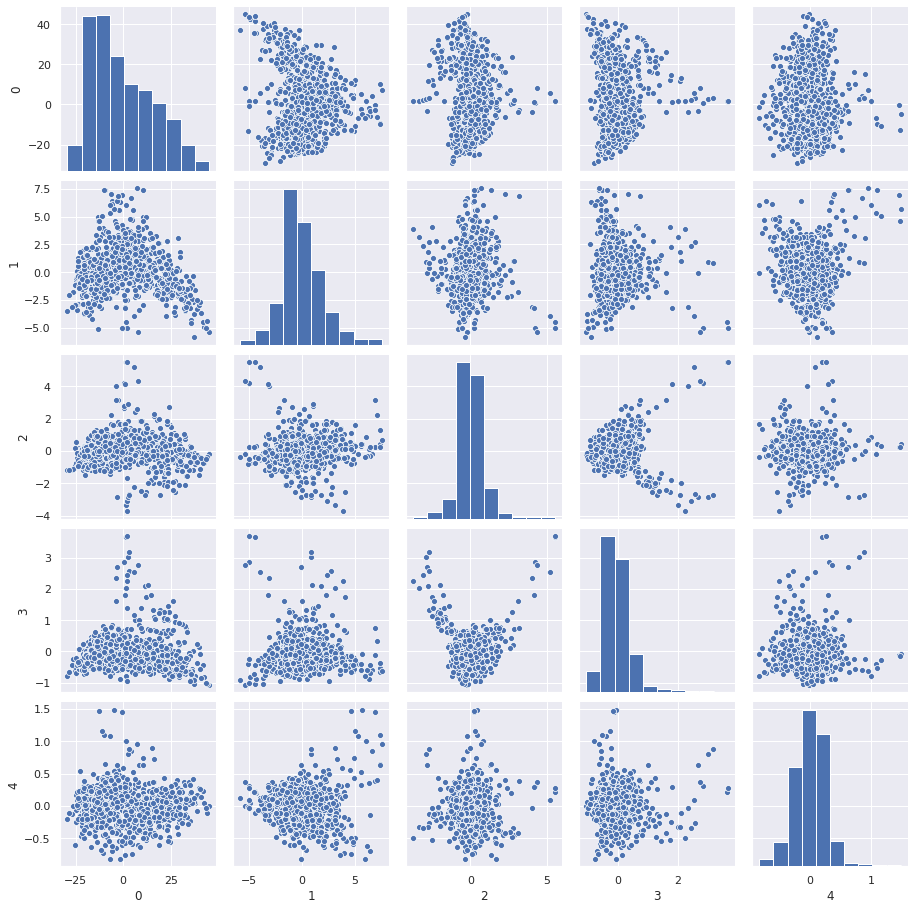

In [76]:
sns.pairplot(pd.DataFrame(hyprT).sample(1000))
plt.show()

In [206]:
n_clusters = 5
# kM = KMeans(n_clusters=n_clusters, random_state=1234) # random_state for reproducability
# nlf = RBFSampler(gamma=0.01,n_components=100,random_state=1234)
nlf = Nystroem(kernel='rbf', gamma=0.01, n_components=100, random_state=1234)
kM = Pipeline([
    ('features',nlf),
    ('cluster',KMeans(n_clusters=n_clusters, random_state=1234))])

In [207]:
H = hypr_c195.reshape(-1, 411)
H = H[:,swir_range]
H = pl.transform(H)
# Htrain = H[mask_c195.reshape(-1)]
# kM.fit(Htrain)
kM.fit(H)
labels = kM.predict(H)

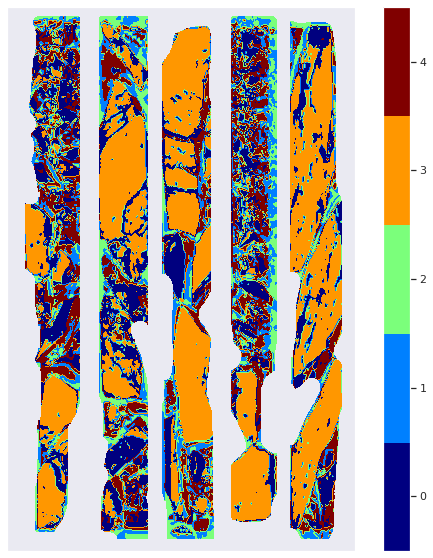

In [208]:
im_labels = labels.reshape(hypr_shape[:2]).astype(float)
im_labels[~mask_c195] = np.nan

v = cm.get_cmap('jet', n_clusters)

plt.figure(figsize=(10,10))
sns.set()
# plt.subplot(1,2,1)
# plt.imshow(img_rgb)
# plt.xticks([])
# plt.yticks([])

# plt.subplot(1,2,2)
plt.imshow(im_labels, cmap=v, vmin=-0.5, vmax=n_clusters-0.5)
plt.colorbar(ticks=np.arange(0,n_clusters))#, shrink=0.3)
plt.xticks([])
plt.yticks([])

# plt.tight_layout()
plt.show()

In [213]:
clusters = [0,3,]
Ilv1 = (labels==clusters[0])
for i in range(1,len(clusters)):
    Ilv1 = np.logical_or(Ilv1, labels==clusters[i])
Hlv2 = H[Ilv1]
nc2 = 1
# kM2 = KMeans(n_clusters=nc2, random_state=1234)
clm2 = KMeans(n_clusters=nc2, random_state=1234)
clm2.fit(nlf.transform(Hlv2))
kM2 = Pipeline([
    ('features',nlf),
    ('cluster', clm2)
])
# kM2.fit(Hlv2)

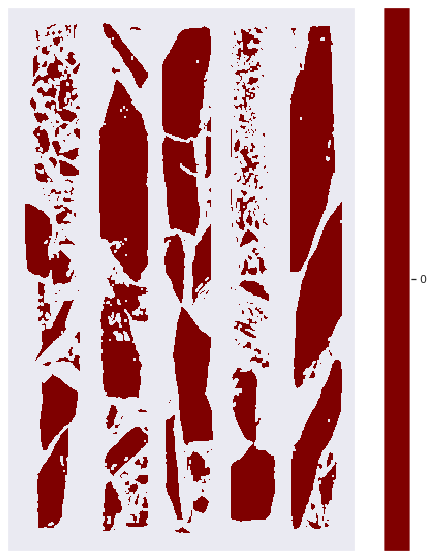

In [214]:
labels2 = kM2.predict(H).astype(float)
labels2[~Ilv1] = np.nan
labels2 = labels2.reshape(hypr_shape[:2])
labels2[~mask_c195] = np.nan

v2 = cm.get_cmap('jet', nc2)

plt.figure(figsize=(10,10))
sns.set()

plt.imshow(labels2, cmap=v2, vmin=-0.5, vmax=nc2-0.5)
plt.colorbar(ticks=np.arange(0,nc2))#, shrink=0.3)
plt.xticks([])
plt.yticks([])

plt.show()

In [215]:
## visual inspection of valid clusters, label them here
clusters2 = [0,]

In [216]:
y = (labels2 == clusters2[0])
for i in range(1, len(clusters2)):
    y = np.logical_or(y, labels2 == clusters2[i])

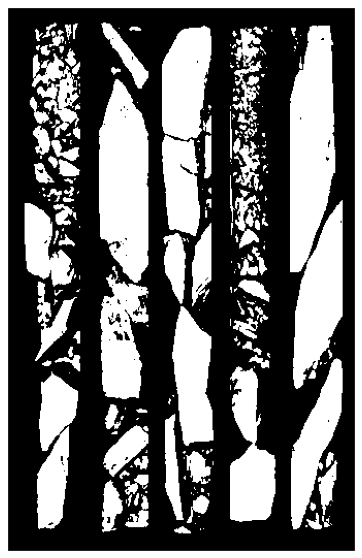

In [217]:
plt.figure(figsize=(10,10))
sns.set()

plt.imshow(y, cmap='binary_r')
# plt.colorbar(ticks=np.arange(0,nc2))#, shrink=0.3)
plt.xticks([])
plt.yticks([])

plt.show()

In [218]:
y = y.reshape(-1)

In [219]:
# y = np.logical_and(y, mask_c195.reshape(-1)) # require that the selected clusters fall in the valid range

In [220]:
df = pd.DataFrame(H)
df['label'] = y

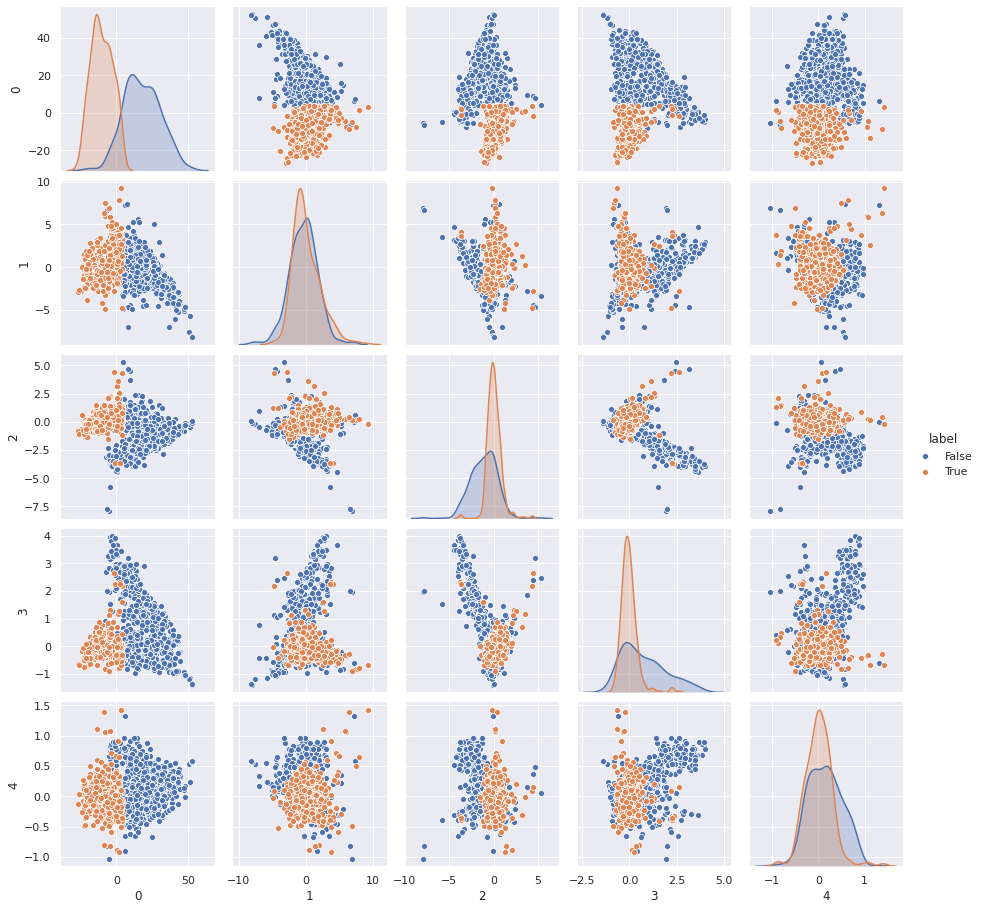

In [221]:
sns.pairplot(df.sample(1000), hue='label')
plt.show()

## Classification
Now we construct a general classifier as applied to the entire image, now labeled. 

In [222]:
clf = MLPClassifier(alpha=1e-4,verbose=True)
clf.fit(H,y);

Iteration 1, loss = 0.09349445
Iteration 2, loss = 0.07855610
Iteration 3, loss = 0.07546534
Iteration 4, loss = 0.07379018
Iteration 5, loss = 0.07231431
Iteration 6, loss = 0.07144687
Iteration 7, loss = 0.07064735
Iteration 8, loss = 0.06985952
Iteration 9, loss = 0.06956855
Iteration 10, loss = 0.06905132
Iteration 11, loss = 0.06852109
Iteration 12, loss = 0.06817956
Iteration 13, loss = 0.06800330
Iteration 14, loss = 0.06758363
Iteration 15, loss = 0.06729693
Iteration 16, loss = 0.06712368
Iteration 17, loss = 0.06681777
Iteration 18, loss = 0.06648366
Iteration 19, loss = 0.06632630
Iteration 20, loss = 0.06614579
Iteration 21, loss = 0.06590701
Iteration 22, loss = 0.06581910
Iteration 23, loss = 0.06552227
Iteration 24, loss = 0.06529537
Iteration 25, loss = 0.06509295
Iteration 26, loss = 0.06496199
Iteration 27, loss = 0.06467266
Iteration 28, loss = 0.06464516
Iteration 29, loss = 0.06455800
Iteration 30, loss = 0.06429239
Iteration 31, loss = 0.06420529
Iteration 32, los

In [223]:
yHat = clf.predict(H)
yHat = yHat.reshape(hypr_shape[:2])
yHat = denoise_wavelet(img_as_float(yHat), sigma=0.15, rescale_sigma=True, method='VisuShrink', wavelet='db2')
yHat = np.clip(np.round(yHat),0,1)

(527, 337, 3) (527, 337)


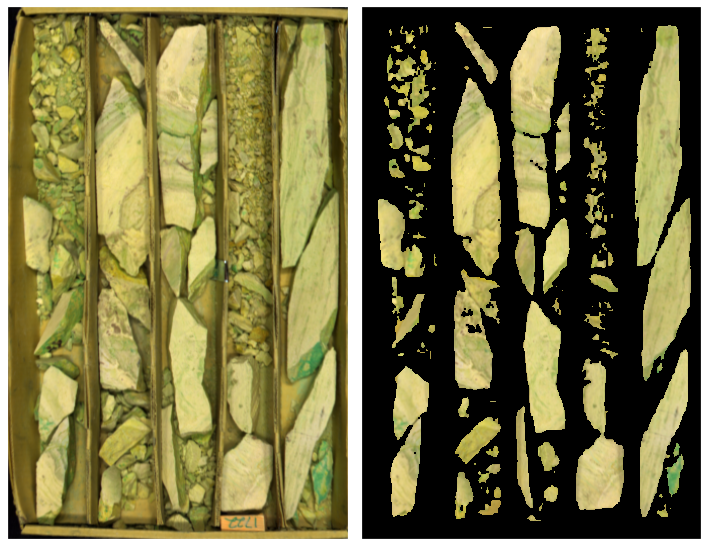

In [224]:
plt.figure(figsize=(10,16))
plt.subplot(1,2,1)
plt.imshow(img_rgb)
plt.xticks([])
plt.yticks([])

plt.subplot(1,2,2)
print(tmp.shape, yHat.shape)
tmp = img_rgb.copy(); tmp[~yHat.astype(bool)] = np.nan
plt.imshow(tmp, cmap='binary_r')
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.savefig('gravel_mask_195.png')

## Validate on Another Image
The `Masker` class takes in all the work we've done above and allows us to plug in any new image to get a mask for that image.

The model pipeline is essentially all the preprocessing steps + the classifier we've constructed, i.e. PCA + scaling + neural network all conviniently combined using the `Pipeline` class from sklearn. We also provide the SWIR range because we have truncated the range of relevance to only SWIR wavelengths. If we comment that part of the code above, we can simply not provide a range at all, and the class will interpret that to mean the entire range.

In [225]:
from source.hyperspectrum_models import Masker
help(Masker)

Help on class Masker in module source.hyperspectrum_models:

class Masker(builtins.object)
 |  Masker(model_pipeline, wavelength_range=None)
 |  
 |  This class produces a callable which inputs a hyperspectral image (crate type)
 |  and outputs a binary mask indicating sections of the image labeled useful (1,True)
 |  and background (0,False).
 |      - model_pipeline : an object with .predict member function that classifies
 |          hyperspectral curves.
 |      - wavelength_range : tuple of length 2, range of usable wavelengths if relevant.
 |  
 |  Methods defined here:
 |  
 |  __call__(self, image)
 |      produces a mask for an image.
 |  
 |  __init__(self, model_pipeline, wavelength_range=None)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |   

In [226]:
preproc = Masker(
    Pipeline([("preprocc",pl),("classifier",clf)]),
    swir_range
)

In [227]:
img = envi.open("data/VNIR and SWIR interval/CMM-111_196_extracted_image.hdr", "data/VNIR and SWIR interval/CMM-111_196_extracted_image.img")
img = img.load()

In [228]:
yHat = preproc(img) # the Masker class is callable and just needs an array of shape [x,y, 411] where x,y are any ints
# yHat = denoise_wavelet(img_as_0float(yHat), sigma=0.15, rescale_sigma=True, method='VisuShrink', wavelet='db2')
# yHat = np.clip(np.round(yHat),0,1)

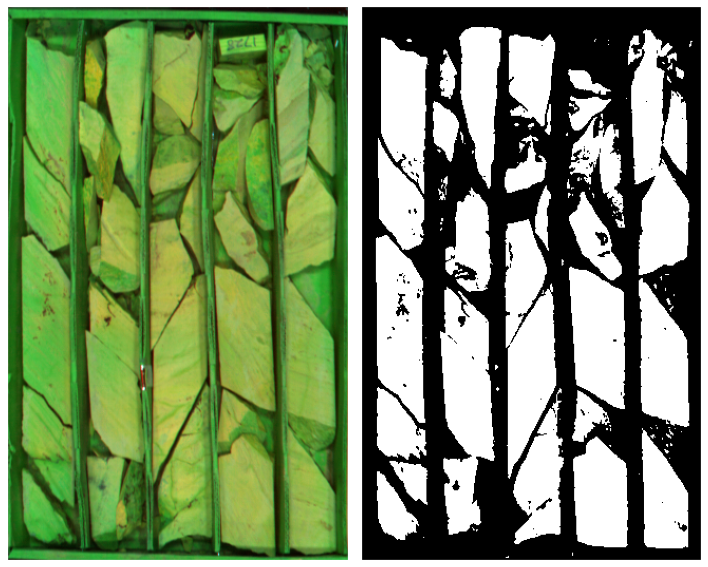

In [229]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(sp.get_rgb(img))
plt.xticks([])
plt.yticks([])

plt.subplot(1,2,2)
plt.imshow(yHat, cmap='binary_r')
plt.xticks([])
plt.yticks([])

# plt.suptitle("CMM-111 196")
plt.tight_layout()
plt.show()

In [230]:
joblib.dump(preproc, 'binaries/masker.joblib') # we save our Masker model for reusing at a later date.

['binaries/masker.joblib']